# Confidence Intervals

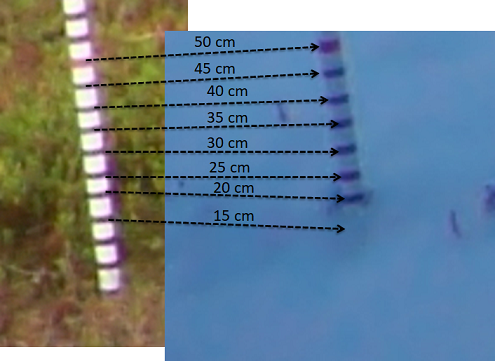


How well do we know something?

We all tried to measure snow depth from this picture, and estimate how confident we were in our guesses. Let's explore our "measurements" in the context of how confident we are in our guesses.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

I have your guesses from this year, and from students in prior years. We can plot a histogram of this data to see what all the guesses look like.

In [2]:
# Load our data, preview the first few rows
snow_depth = pd.read_csv('../data/snow_depth_guesses.csv')
snow_depth.head(3)

class_year  snow_depth_guess_cm
0        2017                   15
1        2017                   15
2        2017                   15

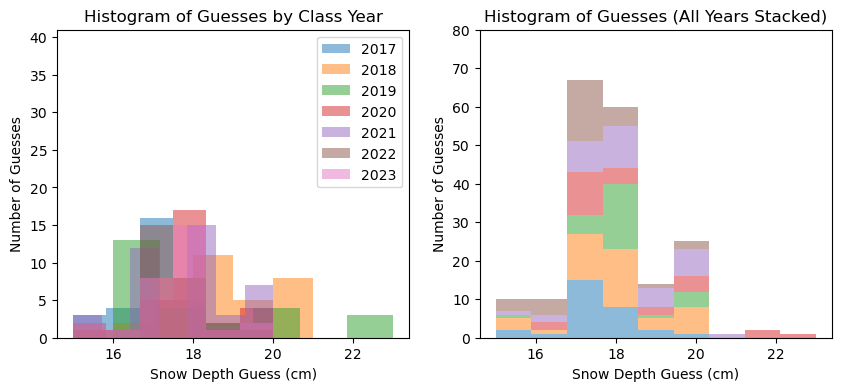

In [3]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

# First make a histogram of each year, overlapping
snow_depth.groupby('class_year').snow_depth_guess_cm.hist(bins='sqrt', lw=2, grid=False, density=False, histtype='bar', alpha=0.5, legend=True, ax=ax[0])
ax[0].set_title('Histogram of Guesses by Class Year')
ax[0].set_xlabel('Snow Depth Guess (cm)')
ax[0].set_ylabel('Number of Guesses')
ax[0].set_ylim((0,41))


# Next make a histogram of each year, but stack them into common bins
stacked_by_year = [snow_depth.snow_depth_guess_cm.loc[snow_depth.class_year==2022].values,
                   snow_depth.snow_depth_guess_cm.loc[snow_depth.class_year==2021].values,
                   snow_depth.snow_depth_guess_cm.loc[snow_depth.class_year==2020].values,
                   snow_depth.snow_depth_guess_cm.loc[snow_depth.class_year==2019].values,
                   snow_depth.snow_depth_guess_cm.loc[snow_depth.class_year==2018].values,
                   snow_depth.snow_depth_guess_cm.loc[snow_depth.class_year==2017].values]
ax[1].hist(stacked_by_year, bins=9, lw=2, density=False, histtype='barstacked', alpha=0.5, stacked=True)
ax[1].set_title('Histogram of Guesses (All Years Stacked)')
ax[1].set_xlabel('Snow Depth Guess (cm)')
ax[1].set_ylabel('Number of Guesses')
ax[1].set_ylim((0,80));

It looks like the guesses converge on 17 or 18 cm, with some slight variability between each class year.

How do we express our confidence of the true value of the snowdepth given these guesses?

We can think about what certainty in our measurements we want (e.g. 90%, 95%), keeping in mind how certain do we need to be for our specific application?

---
To find this we can make a quantile plot. So we first apply quantile mapping to our data:

In [4]:
def cunnane_quantile(df, column_name):
    '''This function will compute the Cunnane plotting position for the values in a column of a dataframe.
    It requres a pandas dataframe, and the column name of interest (a text string) as inputs.
    The output is a new dataframe, ranked (sorted) with an extra column with the plotting position.
    [Steven Pestana - spestana@uw.edu - Oct. 2020]'''
    
    # Rank all our values
    ranked_df = df.sort_values(by=[column_name]).reset_index()
    
    # Calculate the Cunnane plotting position
    ranked_df['cunnane_plotting_position'] = ((ranked_df.index + 1) - (2/5)) / (ranked_df[column_name].count() + (1/5))
        
    return ranked_df

In [5]:
# Apply the cunnane quantile function for our data
snow_depth_q = cunnane_quantile(snow_depth, 'snow_depth_guess_cm')

Then plot our snow depth guesses versus the "probability of non-exceedance" we just calculated.

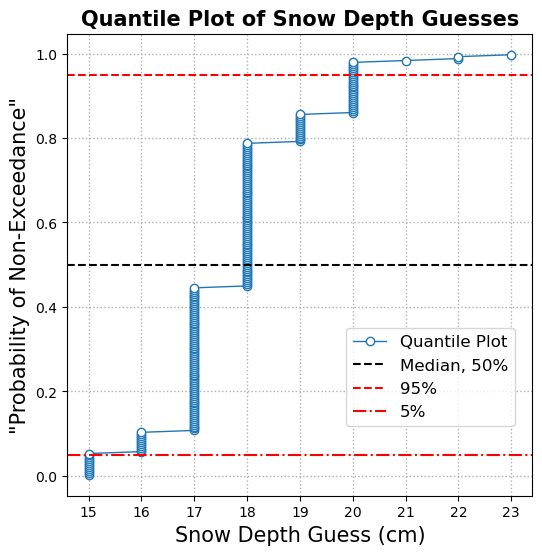

In [6]:
fig, ax = plt.subplots(figsize=(6,6))

# Make the quantile plot
snow_depth_q.plot(x='snow_depth_guess_cm', y='cunnane_plotting_position',linestyle='-', lw=1,  marker='o',markerfacecolor='white', label='Quantile Plot', ax=ax)

# Add horizontal lines at 50%, 95%, 5%
ax.axhline(0.5,linestyle='--', color='k', label='Median, 50%')
ax.axhline(0.95,linestyle='--', color='r', label='95%')
ax.axhline(0.05,linestyle='-.', color='r', label='5%')

# Add labels, title, legend, gridlines
ax.set_xlabel('Snow Depth Guess (cm)', fontsize=15)
ax.set_ylabel('"Probability of Non-Exceedance"', fontsize=15)
ax.set_title('Quantile Plot of Snow Depth Guesses', fontsize=15, fontweight='bold');
plt.legend(loc=(.6,.15),fontsize=12);
plt.grid(linewidth=1,linestyle=':');


It's easy to identify the **median** from these plots, draw a horizontal line across from the 0.5 (or 50%) value. The steepest part of CDF is the peak of PDF (where most our values are concentrated).

The CDF can also show us our confidence intervals. The dashed red lines added to the plot go from 5% to 95%. 

#### Questions:

**What confidence interval is shown between these two lines?** In other words, with what percent certainty do we think, based on our guesses, that the true snow depth is within these dashed lines?

**What is the total probability of the true snow depth falling outside these lines?**

**If we wanted a 95% interval, at what values would be set our confidence lines on this CDF?**

---
We can calculate the snow depth value at a specific quantile using the [scipy.stats.mstats.mquantiles](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.mquantiles.html) function.

Most people said their confidence in their guess was +/- 2 cm.

In [7]:
# we can also compute this function again just looking at the 5%, 50%, and 95% quantiles
q90 = stats.mstats.mquantiles(snow_depth_q.snow_depth_guess_cm, prob=[0.05, 0.5, 0.95], alphap=0.4, betap=0.4) 
# Get our plus or minus values
plus = np.round(q90[2] - q90[1],0)
minus = np.round(q90[1] - q90[0],0)

print('90% Confidence Interval: snow depth = {median} cm, +{plus} or -{minus} cm'.format(median=q90[1],plus=plus,minus=minus))

90% Confidence Interval: snow depth = 18.0 cm, +2.0 or -3.0 cm


That actually matches the 90% confidence interval we compute from all the guesses.

In [8]:
# we can also compute this function again just looking at the 5%, 50%, and 95% quantiles
q95 = stats.mstats.mquantiles(snow_depth_q.snow_depth_guess_cm, prob=[0.025, 0.5, 0.975], alphap=0.4, betap=0.4) 
# Get our plus or minus values
plus = np.round(q95[2] - q95[1],0)
minus = np.round(q95[1] - q95[0],0)
print('95% Confidence Interval: snow depth = {median} cm, +{plus} or -{minus} cm'.format(median=q95[1],plus=plus,minus=minus))

95% Confidence Interval: snow depth = 18.0 cm, +2.0 or -3.0 cm


With 95% confidence, we can say we know the snow depth within +3 or -3 cm. 

Note that confidence intervals are not always symmetric!  The normal distribution is one of the few symmetric distributions.